# Multi-language Semi-Supervised Emotion Recognition via CNN-AE


# Set up

In [1]:
!pip install pywaffle
!pip install tensorflow-addons

     |████████████████████████████████| 565 kB 5.7 MB/s 
     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [2]:
import os
import glob

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import IPython.display as ipd
import librosa
import librosa.display

import tensorflow as tf
import keras
from keras.layers import Input, Reshape, Conv1D, MaxPooling1D, Conv1DTranspose, LSTM
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling1D, BatchNormalization
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras import Sequential
from keras.losses import SparseCategoricalCrossentropy

import tensorflow_addons as tfa 

from scipy.signal import decimate

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

from math import ceil
from pywaffle import Waffle

In [3]:
!git clone https://github.com/aliswh/ser_ae

Cloning into 'ser_ae'...
remote: Enumerating objects: 1888, done.
remote: Counting objects: 100% (1888/1888), done.
remote: Compressing objects: 100% (1814/1814), done.
remote: Total 1888 (delta 73), reused 1881 (delta 72), pack-reused 0
Receiving objects: 100% (1888/1888), 387.81 MiB | 15.99 MiB/s, done.
Resolving deltas: 100% (73/73), done.
Checking out files: 100% (1851/1851), done.


# Data

## Data Loading and Exploration

Datasets description:

Name | Language | Acted | Gender | Emotions | Samples | Sampling Rate
--- | --- | --- | --- | --- |  --- | --- |
EMOVO | Italian | Yes | M/F | disgust, fear, anger, joy, surprise, sadness, neutral | 588 | 48 kHz
EMODB | German | Yes | M/F | anger, boredom, disgust, fear, happiness, sadness, neutral | 800+ | 16 kHz
RAVDESS | English | Yes | M/F | anger, disgust, fear, happiness, sadness, sadness, neutral | 2880 | 48 kHz

In [4]:
data_path = '/content/ser_ae/data'

In [5]:
italian_example = data_path + '/data_training/' + 'emovo' + '/EMOVO/f1/dis-f1-b1' +'.wav'
ipd.Audio(italian_example)

In [6]:
german_example = data_path + '/data_training/' +'emodb' + '/wav/09a01Ea' + '.wav'
ipd.Audio(german_example)

In [7]:
english_example = data_path + '/data_training/' + 'ravdess' + '/Actor_01/03-01-01-01-01-01-01' +'.wav'
ipd.Audio(english_example)

In [8]:
class Signal:
  '''
  Discrete signal (or wave) from audio file.

  Loads audio files as 1D np.array with a timestamp and sampling rate.
  Multiple methods for visualization and transformation are defined.

  Args:
    - path: signal's path, as .wav format
    - dataset_name: from which we load the signal
    - sr: sampling rate default to None. if None, uses files sampling rate
  Returns:
    - Signal object based on Librosa's signal object
  '''
  def __init__(self, path, dataset_name, sr=None):
    self.path = path
    self.dataset_name = dataset_name
    # extract file name
    self.name = path.split('/')[-1].split('.')[0]
    # data loading
    if type(path) is str:
      self.signal, self.sampling_rate = librosa.load(path, sr=sr)
    else:
      raise TypeError('Input a single path string to the file.')
    self.len_signal = len(self.signal)
    self.duration = self.len_signal/self.sampling_rate

  def copy(self):
    obj = type(self).__new__(self.__class__)
    obj.__dict__.update(self.__dict__)
    return obj

  def listen(self):
    return ipd.Audio(self.path)

  def __repr__(self):
    return f'{self.__class__.__name__} of duration {self.duration}s.'

In [9]:
EMOTIONS = [
  'NEUTRAL',
  'SAD',
  'ANGRY',
  'HAPPY',
  'FEAR',
  'DISGUST'
  ]

# italian
EMOVO_emotions = [
  'neu', # neutral
  'tri', # sad
  'rab', # angry
  'gio', # happy
  'pau', # fear
  'dis'  # disgust
  ]

# german
EMODB_emotions = [
  'N', # neutral
  'T', # sad
  'W', # angry
  'F', # happy
  'A', # fear
  'E', # disgust
  ]

# english
RAVDESS_emotions = [
  '01', # neutral
  '04', # sad
  '05', # angry
  '03', # happy
  '06', # fear
  '07', # disgust
  ]

In [10]:
GENDER = ['F', 'M']

EMOVO_gender = ['f','m']

EMODB_gender = [
    ['08','09','13','14','16'], # female
    ['03','10','11','12','15']  # male
  ]
  
# RAVDESS_gender = Odd numbered actors are male, even numbered actors are female

In [11]:
data_path_training = data_path + '/data_training/'
data_path_testing = data_path + '/data_testing/'

fileformat = 'wav'

data, data_testing = [[[] for i in range(3)]  for i in range(2)] 
labels, labels_testing = [[[] for i in range(3)]  for i in range(2)] 

dataset_composition = []

SAMPLING_RATE = {
    'emovo':48000,
    'emodb':16000, # 48/16=3
    'ravdess':48000
}
lang_str = ['Italian', 'German', 'English']

def get_emotion_gender_language(filename, db='emovo'):
  '''
  Reads filename and parses it to get information about the signal stored in the file.

  Args:
    - filename: from original dataset
    - db: dataset from which we load the signal
  Returns:
    - Triplet of emotion, gender, and language normalized for this application
  '''
  
  if db=='emovo':
    s = filename.split('-')
    if s[0] not in EMOVO_emotions: return None, None, None
    y = EMOTIONS[EMOVO_emotions.index(s[0])]
    z = GENDER[EMOVO_gender.index(s[1][0])]
    w = 'ita'

  if db=='emodb':
    gender, emotion = filename[:2], filename[5]
    if emotion not in EMODB_emotions: return None, None, None
    y = EMOTIONS[EMODB_emotions.index(emotion)]
    z = 'F' if gender in EMODB_gender[0] else 'M'
    w = 'ger'

  if db=='ravdess':
    s = filename.split('-')
    if s[2] not in RAVDESS_emotions: return None, None, None
    y = EMOTIONS[RAVDESS_emotions.index(s[2])]
    z = 'F' if int(s[5]) % 2 == 0 else 'M' 
    w = 'eng'
    
  return y, z, w

def read_dataset(datapath, dirname, data_array, label_array, dir_type):
  '''
  Reads dataset from given datapath into defined given lists.

  Args:
    - datapath: full path string
    - dirname: name of directory 
    - data_array: array in which to store loaded data
    - label_array: array in which to store loaded labels
    - dir_type: if training or testing
  Returns:
    - None
  '''
  d, l = [], []
  for filename in glob.iglob(datapath + dirname + '**/**', recursive=True):
    if not os.path.isdir(filename) and filename[-3:] == fileformat: 
      x = Signal(filename, dirname, sr=SAMPLING_RATE[dirname])
      y, z, w = get_emotion_gender_language(x.name, db=dirname)
      if y is not None:
        d.append(x)
        l.append(np.array([y,z,w]))
  data_array.extend(d)
  label_array.extend(l)
  dataset_composition.append((dirname, dir_type, len(d)))
  print(f"For {dirname} we have {len(d)} data points, and {len(l)} labels.")

In [12]:
print(f'. . . Loading training data: \n')
for i,db in enumerate(SAMPLING_RATE.keys()):
  read_dataset(data_path_training, db, data[i], labels[i], 'training')

print(f'\n. . . Loading testing data: \n')
for i,db in enumerate(SAMPLING_RATE.keys()):
  read_dataset(data_path_testing, db, data_testing[i], labels_testing[i], 'testing')

print(f'\n. . . Loading complete! \n Total of {len(data)} training data points, and {len(data_testing)} testing points.')
dataset_composition

. . . Loading training data: 

For emovo we have 336 data points, and 336 labels.
For emodb we have 362 data points, and 362 labels.
For ravdess we have 352 data points, and 352 labels.

. . . Loading testing data: 

For emovo we have 168 data points, and 168 labels.
For emodb we have 92 data points, and 92 labels.
For ravdess we have 176 data points, and 176 labels.

. . . Loading complete! 
 Total of 3 training data points, and 3 testing points.


[('emovo', 'training', 336),
 ('emodb', 'training', 362),
 ('ravdess', 'training', 352),
 ('emovo', 'testing', 168),
 ('emodb', 'testing', 92),
 ('ravdess', 'testing', 176)]

In [13]:
print(f'So we have {sum([d[2] for d in dataset_composition[:3]])} of the data for training and {sum([d[2] for d in dataset_composition[3:]])} for testing.')
print(f'And a mean of {np.mean([x[2] for x in dataset_composition[:3]])} examples per dataset.')

So we have 1050 of the data for training and 436 for testing.
And a mean of 350.0 examples per dataset.


## Data Visualization

In [14]:
viz_data = [datapoint for subdata in data for datapoint in subdata] + [datapoint for subdata in data_testing for datapoint in subdata]
viz_labels = [l for sublabel in labels for l in sublabel] 
viz_labels_test = [l for sublabel in labels_testing for l in sublabel]

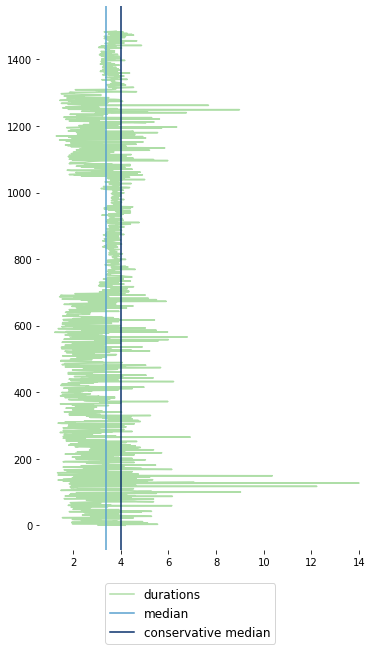

In [15]:
number = 10
cmap = plt.get_cmap('Greens')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

durations = [len(d.signal)/d.sampling_rate for d in viz_data]
m = np.median(durations)
conservative_median = ceil(m)

plt.figure(figsize=(6,10))
plt.plot( durations, range(len(durations)), color=colors[3])

cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

plt.axvline(m, color=colors[5])
plt.axvline(conservative_median, color=colors[9])
plt.legend(labels=['durations','median','conservative median'], fontsize='large', loc='upper center', bbox_to_anchor=(0.45, -0.05))

for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
ax = plt.gca()

plt.show()

In [16]:
def plot_waffle(c, ltrain, ltest, pos, col_start, col_end, number_cmap = 7, figsize=4):
  A_waffle_cmap = plt.get_cmap('Greens')
  A_waffle_colors = [A_waffle_cmap(i) for i in np.linspace(0, 1, number_cmap)]

  B_waffle_cmap = plt.get_cmap('Blues')
  B_waffle_colors = [B_waffle_cmap(i) for i in np.linspace(0, 1, number_cmap)]

  count_occ = lambda x,y,pos : sum([1 for w in y if w[pos]==x])
  c_count_1 = dict(zip([l+' training' for l in c], [count_occ(l, ltrain, pos) for l in c]))
  c_count_2 = dict(zip([l+' testing'for l in c], [count_occ(l, ltest, pos) for l in c]))

  waffle_data = dict()
  waffle_data.update(c_count_1)
  waffle_data.update(c_count_2)
  
  waffle_data = {k:v/sum(waffle_data.values()) for k,v in waffle_data.items()}

  fig = plt.figure(
      FigureClass=Waffle, 
      rows=15,
      columns = 15,
      values=waffle_data, 
      colors=A_waffle_colors[col_start:col_end]+B_waffle_colors[col_start:col_end],
      labels=[f"{k} ({int(v / sum(waffle_data.values()) * 100)}%)" for k, v in waffle_data.items()],
      legend={'loc': 'upper left', 'bbox_to_anchor': (0,0), 'ncol': 1, 'framealpha': 0}
  )
  fig.set_size_inches(figsize,figsize)
  fig.set_dpi(150)
  plt.show()

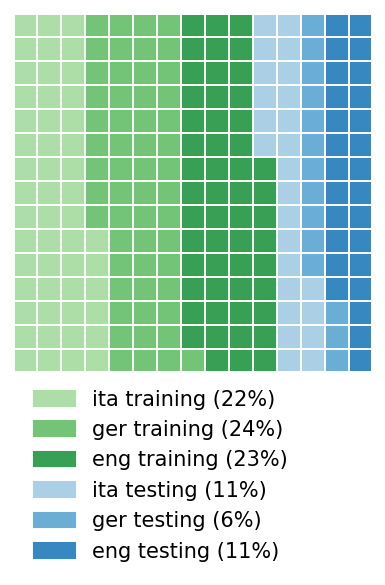

In [17]:
plot_waffle(['ita','ger','eng'], viz_labels, viz_labels_test, 2, 2, 5)

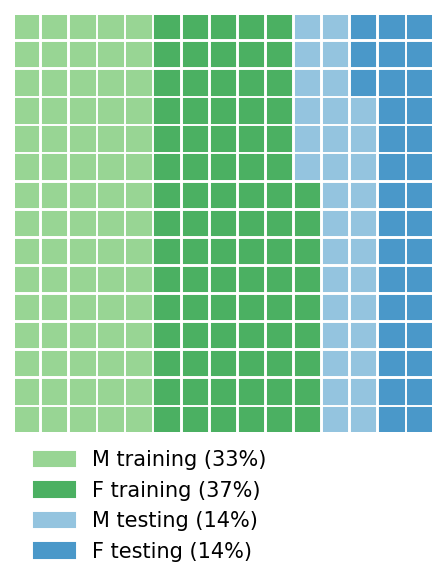

In [18]:
plot_waffle(['M','F'],  viz_labels, viz_labels_test,  1, 2, 4, number_cmap=6)

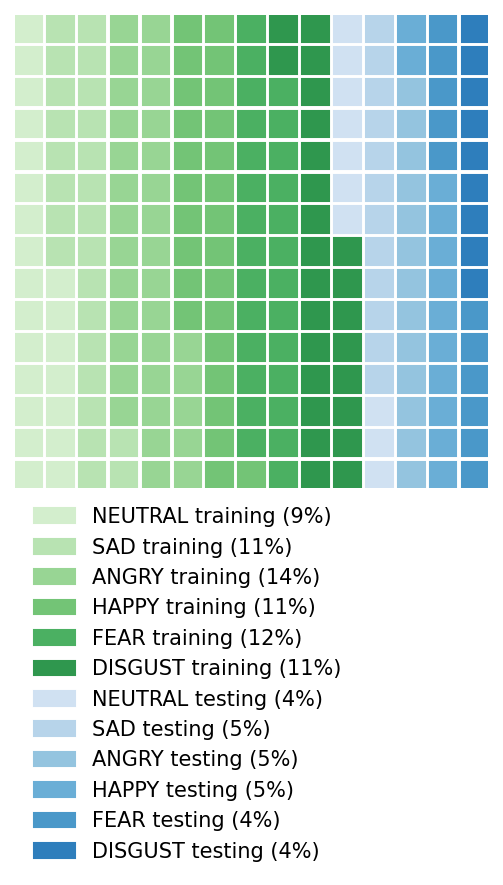

In [19]:
plot_waffle(EMOTIONS,  viz_labels, viz_labels_test,  0, 2, 8, number_cmap=11, figsize=6)

## Data Preprocessing

In [20]:
wanted_len = 8000 # 1 second at 8kHz

downsampling_factor = {
    'emovo':6,  # = 48k / 8k
    'emodb':2,  # = 16k / 8k
    'ravdess':6 # = 48k / 8k
  }

def extract_subsignals(data, labels, wanted_len):
  '''
  Process signals to get subsignals of given length.
  Downsampling factor defined outside function.

  Args:
    - data: array in which to store loaded data
    - labels: array in which to store loaded labels
    - wanted_len: length of wanted signal in number of samples per second (Hz)
  Returns:
    - Numpy arrays of processed signals and their labels
  '''

  new_data = []
  new_labels = []
  
  for i,signal in enumerate(data):
    item = decimate(signal.signal, downsampling_factor[signal.dataset_name])
    l = len(item)
    n_sections = l//wanted_len+1
    item = np.pad(item, (0, n_sections*wanted_len-l), 'constant')
    item = item.reshape(-1, wanted_len)
    if item[-1][-1] == 0: item = item[:-1] # discard last empty subsignal
    for subsignal in item:
      new_data.append(subsignal)
      new_labels.append(labels[i])
  
  return np.array(new_data), np.array(new_labels)

shaped_data, shaped_labels = [[[] for i in range(3)]  for i in range(2)] 
for i,d in enumerate(zip(data,labels)):
  shaped_data[i], shaped_labels[i] = extract_subsignals(d[0], d[1], wanted_len)

In [21]:
for d in shaped_data: print(d.shape)

(896, 8000)
(807, 8000)
(1124, 8000)


In [22]:
N_MELS = 16
N_MFCCS = 12

class SignalFeatures():
  def __init__(self, signal, label, N_MELS, N_MFCCS):
    '''
    Process signals to get subsignals of given length.
    Downsampling factor defined outside function.

    Args:
      - signal: signal as numpy array
      - label
      - N_MELS: number of Mels
      - N_MFCCS: number of MFCCs
    Returns:
      - SignalFeatures object which store the signal, its extracted features and a visualitation method.
    '''
    SAMPLING_RATE = {
    'ita':48000,'eng':16000,'ger':48000
    }
    self.signal = signal
    self.sr = SAMPLING_RATE[label[2]]
    self.label = label[0]
    self.mel = librosa.power_to_db(librosa.feature.melspectrogram(self.signal, sr=self.sr, n_mels=N_MELS), ref=1)
    self.mfccs = librosa.feature.mfcc(y=self.signal, sr=self.sr, n_mfcc=N_MFCCS)
    self.chroma = librosa.feature.chroma_stft(self.signal, sr=self.sr)
    self.centroid = librosa.feature.spectral_centroid(self.signal, sr=self.sr)

    self.features = self.mel
    for f in [self.mfccs, self.chroma, self.centroid]:
      self.features = np.concatenate((self.features,f), axis=0)

  def plot(self, spec):
    if spec == 'mel' : x = self.mel
    if spec == 'mfccs': x = self.mfccs
    if spec == 'chroma': x = self.chroma
    if spec == 'centroid' : x = self.centroid

    plt.figure(figsize=(10, 3))
    librosa.display.specshow(x, sr=self.sr,
                            x_axis="time", 
                            cmap='GnBu_r')
    plt.colorbar() # format="%+2.f"
    plt.title(f"{spec}, {self.label}")
    plt.show()

feature_data = [[] for i in range(3)]
for i,d in enumerate(zip(shaped_data,shaped_labels)):
  feature_data[i] = [SignalFeatures(shaped_data[i][j], shaped_labels[i][j], N_MELS, N_MFCCS) for j in range(len(d[0]))]

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


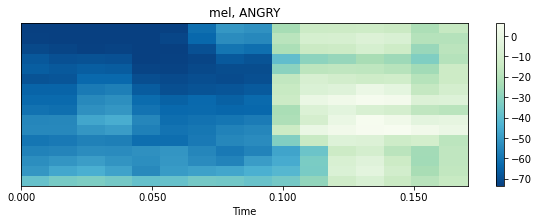

In [23]:
feature_data[0][40].plot('mel')

In [24]:
feature_data[0][40].features.shape, feature_data[0][40].chroma.shape, feature_data[0][40].centroid.shape, feature_data[0][40].mfccs.shape, feature_data[0][40].mel.shape

((41, 16), (12, 16), (1, 16), (12, 16), (16, 16))

In [25]:
feature_ds = [[s.features for s in d] for d in feature_data]

In [26]:
target_labels = [[] for i in range(3)]
LabelEncoder_ = LabelEncoder()
for i,d in enumerate(shaped_labels):
  target_labels[i]  = LabelEncoder_.fit_transform([l[0] for l in d])

After extracting features, scale raw data for raw signal learning.

In [27]:
LabelEncoder_2 = LabelEncoder()
target_labels_raw = [[] for i in range(3)]
for i,d in enumerate(shaped_labels):
  target_labels_raw[i] = LabelEncoder_2.fit_transform([l[0] for l in d])

scaler = MinMaxScaler()
for i in range(len(shaped_data)):
  shaped_data[i] = scaler.fit_transform(shaped_data[i])

Applying preprocessing also to testing data for later evaluation.

In [28]:
shaped_data_testing, shaped_labels_testing = [[[] for i in range(3)]  for i in range(2)] 
for i,d in enumerate(zip(data_testing,labels_testing)):
  shaped_data_testing[i], shaped_labels_testing[i] = extract_subsignals(d[0], d[1], wanted_len)

# feature-based learning data

feature_testing = [[] for i in range(3)]
for i,d in enumerate(zip(shaped_data_testing,shaped_labels_testing)):
  feature_testing[i] = [SignalFeatures(shaped_data_testing[i][j], shaped_labels_testing[i][j], N_MELS, N_MFCCS) for j in range(len(d[0]))]

feature_testing = [[s.features for s in d] for d in feature_testing]
target_labels_testing = [[] for i in range(3)]
for i,d in enumerate(shaped_labels_testing):
  target_labels_testing[i]  = LabelEncoder_.fit_transform([l[0] for l in d])

# raw data
for i in range(len(shaped_data_testing)):
  shaped_data_testing[i] = scaler.fit_transform(shaped_data_testing[i])

target_labels_raw_testing = [[] for i in range(3)]
for i,d in enumerate(shaped_labels_testing):
  target_labels_raw_testing[i] = LabelEncoder_2.fit_transform([l[0] for l in d])

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


# Training

In [29]:
evaluations = {
    'feat_DNN' : {}, # features throught dense NN
    'feat_CNN' : {}, # features throught convolutional NN
    'AE_raw_SVM' : {}, # encoded signal + SVM
    'AE_raw_MLP' : {}, # encoded signal + MLP
    'AE_raw_CNN' : {}, # encoded signal + CNN
    'feat_all_CNN': {},# encoded signal + CNN , full dataset
    'AE_feat_raw_CNN' : {}, # encoded signal + features + CNN
    'AE_feat_raw_all_CNN' : {}, # encoded signal + features + CNN , full dataset
}

n_classes = len(LabelEncoder_.classes_)
ckappa = tfa.metrics.CohenKappa(num_classes=6, sparse_labels=True)
compute_class_w = lambda y: dict(zip(np.unique(y), class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y))) 

model_params = {
    'batch_size':16, 
    'epochs':100, 
    'verbose':1, 
    'validation_split':0.2,
    'shuffle':True
}

saved_encoder_path = '/content/ser_ae/' + 'encoder{0}.h5'

## Supervised Learning on extracted features

### Dense Neural Network

In [30]:
def build_nn(print_summary=False):
  input_shape = shaped_data[0][0].shape[0]
  output_shape = n_classes

  model_dl = Sequential()
  model_dl.add(Input(shape=input_shape, name='input'))
  model_dl.add(Dense(3, activation='relu', name='Dense_1'))
  model_dl.add(BatchNormalization(name='BatchNormalization_1'))
  model_dl.add(Dropout(0.2, name='Dropout_1'))
  model_dl.add(Dense(3, activation='relu', name='Dense_2'))
  model_dl.add(BatchNormalization(name='BatchNormalization_2'))
  model_dl.add(Dropout(0.2, name='Dropout_2'))
  model_dl.add(Dense(output_shape, activation='softmax', name='output'))

  if print_summary: model_dl.summary()
  return model_dl

def build_and_train_cnn_mel(data,labels):
  eva, pre = [], []
  history_nn = {}
  for i,X in enumerate(data):
    x = data[i]
    y = labels[i]

    model_nn = build_nn()
    # training
    model_nn.compile(
      loss='sparse_categorical_crossentropy', 
      optimizer='adam', 
      metrics=[ckappa,'accuracy'])
    
    history_nn[i] = model_nn.fit(x, y, **model_params, class_weight=compute_class_w(y))

    # evaluation
    xt = shaped_data_testing[i]
    yt = target_labels_raw_testing[i]
    eva.append(model_nn.evaluate(xt, yt)[1])
    pre.append(np.argmax(model_nn.predict(xt), axis=1))

  evaluations['feat_DNN']['ckappa'] = eva
  evaluations['feat_DNN']['predictions'] = pre 
  return history_nn

history_nn = build_and_train_cnn_mel(shaped_data, target_labels_raw)

Epoch 1/100
45/45 [==============================] - 3s 20ms/step - loss: 1.8089 - cohen_kappa: -0.0159 - accuracy: 0.1466 - val_loss: 1.7919 - val_cohen_kappa: 4.8769e-04 - val_accuracy: 0.1778
Epoch 2/100
45/45 [==============================] - 0s 8ms/step - loss: 1.7950 - cohen_kappa: -0.0064 - accuracy: 0.1550 - val_loss: 1.7926 - val_cohen_kappa: 0.0000e+00 - val_accuracy: 0.1333
Epoch 3/100
45/45 [==============================] - 0s 7ms/step - loss: 1.7948 - cohen_kappa: -0.0083 - accuracy: 0.1536 - val_loss: 1.7932 - val_cohen_kappa: 0.0000e+00 - val_accuracy: 0.1333
Epoch 4/100
45/45 [==============================] - 0s 7ms/step - loss: 1.7953 - cohen_kappa: -0.0017 - accuracy: 0.1592 - val_loss: 1.7936 - val_cohen_kappa: -0.0064 - val_accuracy: 0.1278
Epoch 5/100
45/45 [==============================] - 0s 7ms/step - loss: 1.7947 - cohen_kappa: 0.0000e+00 - accuracy: 0.1606 - val_loss: 1.7943 - val_cohen_kappa: -0.0064 - val_accuracy: 0.1278
Epoch 6/100
45/45 [=============

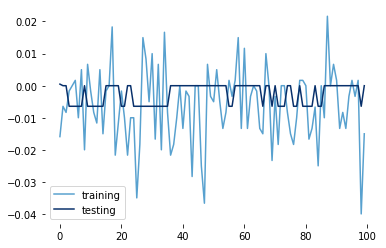

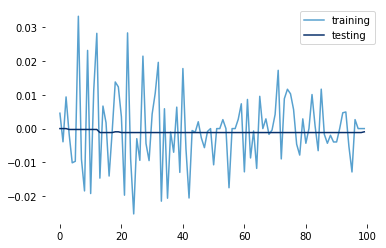

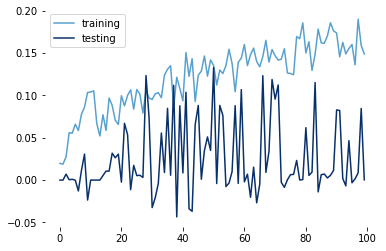

In [31]:
for v in history_nn.values():
  plt.plot(v.history['cohen_kappa'], label='training', color=colors[5])
  plt.plot(v.history['val_cohen_kappa'], label='testing', color=colors[9])
  for pos in ['right', 'top', 'bottom', 'left']:
      plt.gca().spines[pos].set_visible(False)
  plt.legend()
  plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 3)                 24003     
                                                                 
 BatchNormalization_1 (Batch  (None, 3)                12        
 Normalization)                                                  
                                                                 
 Dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 Dense_2 (Dense)             (None, 3)                 12        
                                                                 
 BatchNormalization_2 (Batch  (None, 3)                12        
 Normalization)                                                  
                                                                 
 Dropout_2 (Dropout)         (None, 3)                

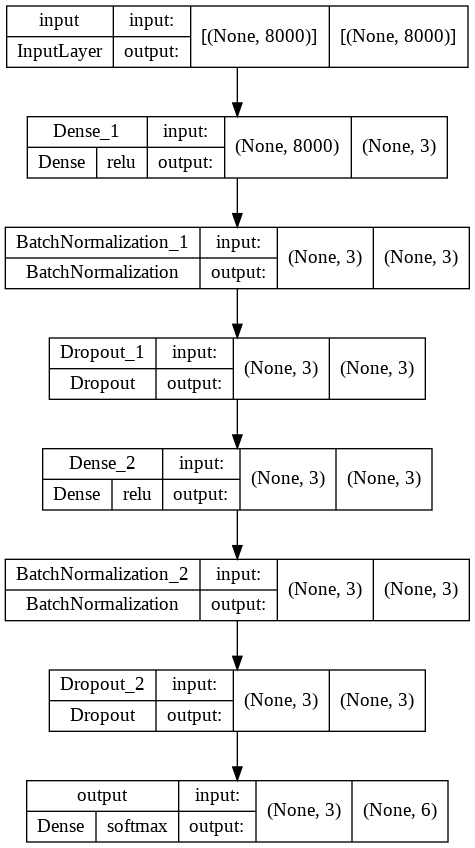

In [32]:
plot_model(build_nn(print_summary=True), show_layer_activations=True, show_shapes=True)

### Convolutional Neural Network 

In [33]:
def build_cnn_mel(print_summary=False):
  input_shape = (*feature_ds[0][0].shape,1)
  output_shape = n_classes

  model_mel = Sequential()
  model_mel.add(Conv2D(filters=3, kernel_size=3, activation='relu', input_shape=input_shape))
  model_mel.add(Dropout(0.5))
  model_mel.add(MaxPooling2D(pool_size=3, padding='same'))
  model_mel.add(Flatten())
  model_mel.add(Dense(output_shape, activation='sigmoid'))

  if print_summary: model_mel.summary()
  return model_mel

def build_and_train_cnn_mel(data,labels):
  history_mel = {}
  eva, pre = [], []
  for i,X in enumerate(data):
    # data
    x = np.expand_dims(np.array(X),axis=3)
    y = labels[i]

    # training
    model_mel = build_cnn_mel()
    model_mel.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=[ckappa])

    history_mel[i] = model_mel.fit(x, y, **model_params, class_weight=compute_class_w(y))

    # evaluation
    xt = np.expand_dims(np.array(feature_testing[i]),axis=3)
    yt = target_labels_testing[i]
    eva.append(model_mel.evaluate(xt, yt)[1])
    pre.append(np.argmax(model_mel.predict(xt), axis=1)) 

  evaluations['feat_CNN']['ckappa'] = eva
  evaluations['feat_CNN']['predictions'] = pre 
  return history_mel

history_mel = build_and_train_cnn_mel(feature_ds, target_labels)

Epoch 1/100
45/45 [==============================] - 1s 14ms/step - loss: 148.5924 - cohen_kappa: 0.0024 - val_loss: 170.1608 - val_cohen_kappa: -0.0453
Epoch 2/100
45/45 [==============================] - 0s 7ms/step - loss: 78.9794 - cohen_kappa: 0.0279 - val_loss: 160.0608 - val_cohen_kappa: 0.0036
Epoch 3/100
45/45 [==============================] - 0s 8ms/step - loss: 60.3035 - cohen_kappa: -0.0155 - val_loss: 148.7596 - val_cohen_kappa: 0.0116
Epoch 4/100
45/45 [==============================] - 0s 8ms/step - loss: 47.7467 - cohen_kappa: 0.0429 - val_loss: 146.9496 - val_cohen_kappa: 0.0350
Epoch 5/100
45/45 [==============================] - 0s 8ms/step - loss: 34.4162 - cohen_kappa: 0.0316 - val_loss: 157.5087 - val_cohen_kappa: 0.0260
Epoch 6/100
45/45 [==============================] - 0s 7ms/step - loss: 31.5651 - cohen_kappa: 0.0679 - val_loss: 134.0067 - val_cohen_kappa: 0.0508
Epoch 7/100
45/45 [==============================] - 0s 8ms/step - loss: 23.2698 - cohen_kappa: 

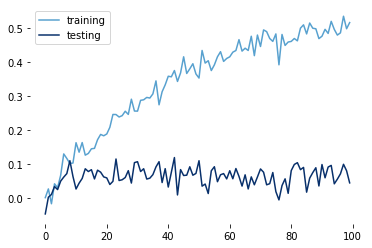

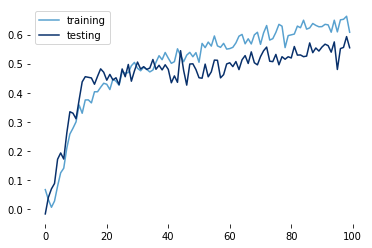

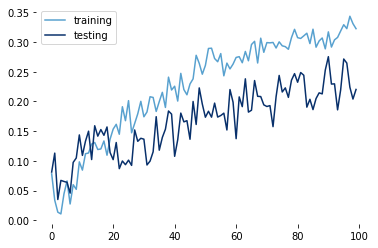

In [34]:
for v in history_mel.values():
  plt.plot(v.history['cohen_kappa'], label='training', color=colors[5])
  plt.plot(v.history['val_cohen_kappa'], label='testing', color=colors[9])
  for pos in ['right', 'top', 'bottom', 'left']:
      plt.gca().spines[pos].set_visible(False)
  plt.legend()
  plt.show()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 39, 14, 3)         30        
                                                                 
 dropout_3 (Dropout)         (None, 39, 14, 3)         0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 5, 3)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 195)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1176      
                                                                 
Total params: 1,206
Trainable params: 1,206
Non-trainable params: 0
____________________________________________________

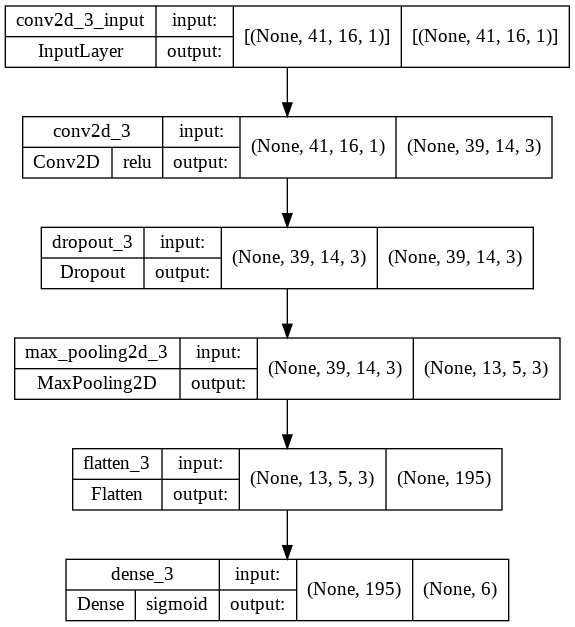

In [35]:
plot_model(build_cnn_mel(print_summary=True), show_layer_activations=True, show_shapes=True)

#### On full dataset

In [36]:
feature_data_all = np.concatenate([i for i in feature_ds])
feature_data_all_testing = np.concatenate([i for i in feature_testing])
feature_data_all.shape, feature_data_all_testing.shape

((2827, 41, 16), (1190, 41, 16))

In [37]:
full_target_labels = np.concatenate([t for t in target_labels_raw])
full_target_labels_testing = np.concatenate([t for t in target_labels_raw_testing])
full_target_labels.shape, full_target_labels_testing.shape

((2827,), (1190,))

In [38]:
def build_and_train_cnn_all(data,labels,testdata,testlabels):
  # data
  x = np.expand_dims(np.array(data),axis=3)
  y = labels

  # training
  model = build_cnn_mel()
  model.compile(
  loss='sparse_categorical_crossentropy', 
  optimizer='adam', 
  metrics=[ckappa])

  history = model.fit(x, y, **model_params, class_weight=compute_class_w(y))

  # evaluation
  xt = np.expand_dims(np.array(testdata),axis=3)
  yt = testlabels

  evaluations['feat_all_CNN']['ckappa'] = model.evaluate(xt, yt)[1]
  evaluations['feat_all_CNN']['predictions'] = np.argmax(model.predict(xt), axis=1) 
  return history

history_feat_all = build_and_train_cnn_all(feature_data_all, full_target_labels,
                                           feature_data_all_testing, full_target_labels_testing)

Epoch 1/100
142/142 [==============================] - 2s 9ms/step - loss: 467.1154 - cohen_kappa: 0.0426 - val_loss: 60.4431 - val_cohen_kappa: -0.0071
Epoch 2/100
142/142 [==============================] - 1s 7ms/step - loss: 75.8979 - cohen_kappa: 0.0379 - val_loss: 16.9443 - val_cohen_kappa: 0.0057
Epoch 3/100
142/142 [==============================] - 1s 8ms/step - loss: 29.4182 - cohen_kappa: 0.0397 - val_loss: 8.3375 - val_cohen_kappa: 0.0408
Epoch 4/100
142/142 [==============================] - 1s 7ms/step - loss: 20.4125 - cohen_kappa: 0.0630 - val_loss: 7.3916 - val_cohen_kappa: 0.0268
Epoch 5/100
142/142 [==============================] - 1s 8ms/step - loss: 15.5634 - cohen_kappa: 0.0487 - val_loss: 5.2858 - val_cohen_kappa: 0.0443
Epoch 6/100
142/142 [==============================] - 1s 8ms/step - loss: 12.2467 - cohen_kappa: 0.0657 - val_loss: 5.3581 - val_cohen_kappa: 0.0526
Epoch 7/100
142/142 [==============================] - 1s 7ms/step - loss: 10.4037 - cohen_kappa

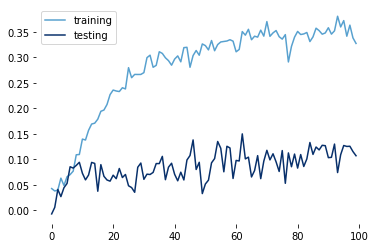

In [39]:
plt.plot(history_feat_all.history['cohen_kappa'], label='training', color=colors[5])
plt.plot(history_feat_all.history['val_cohen_kappa'], label='testing', color=colors[9])
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.legend()
plt.show()

## Semi-supervised Learning 

### Convolutional Autoencoder

In [40]:
class Autoencoder:
  def build_e(self):
    e = Conv1D(self.conv_shape_1,self.conv_window_size, activation='relu', name='Conv1D_1',
              strides=self.conv_stride, padding='same')(self.input_sig) 
    e = MaxPooling1D(self.maxpool_shape_1, padding='same', name='maxpool_1')(e)
    e = Dropout(self.dropout_rate, name='dropout_1')(e)

    e = Conv1D(self.conv_shape_2,self.conv_window_size, activation='relu', name='Conv1D_2',
              strides=self.conv_stride, padding='same')(e) 
    e = MaxPooling1D(self.maxpool_shape_2, padding='same', name='maxpool_2')(e)

    e = Conv1D(self.conv_shape_3,self.conv_window_size, activation='relu', name='Conv1D_3',
              strides=self.conv_stride, padding='same')(e) 
    e = MaxPooling1D(self.maxpool_shape_3, padding='same', name='maxpool_3')(e)

    e = Dropout(self.dropout_rate, name='dropout_2')(e)

    e = Dense(16, name='dense_1')(e)
    e_shapes = (e.shape[1], e.shape[2])
    latent = Flatten(name='latent')(e) 

    return latent, e_shapes

  def build_d(self):
    d = Reshape(self.e_shapes, name='reshape')(self.e)

    d = Conv1DTranspose(self.conv_shape_3, self.conv_window_size, name='Conv1D-traspose_1',
                        strides=self.conv_stride, activation='relu', padding='same')(d) 
    d = UpSampling1D(self.maxpool_shape_2, name='upsamp_1')(d) 
    d = Conv1DTranspose(self.conv_shape_2, self.conv_window_size, name='Conv1D-traspose_2',
                        strides=self.conv_stride, activation='relu', padding='same')(d) 
    d = UpSampling1D(self.maxpool_shape_2, name='upsamp_2')(d) 
    d = Conv1DTranspose(self.conv_shape_1, self.conv_window_size, name='Conv1D-traspose_3',
                        strides=self.conv_stride, activation='relu', padding='same')(d) 
    d = UpSampling1D(self.maxpool_shape_1, name='upsamp_3')(d) 
    d = Conv1DTranspose(1, self.conv_window_size, name='output',
                      activation='sigmoid', padding='same')(d)
    return d

  def train_ae(self,data):
    optimizer = 'adadelta'

    self.ae.compile(
        optimizer=optimizer, 
        loss='mse'
        ) 

    model_params_ae = {
        'batch_size':16, 
        'epochs':100, 
        'verbose':1, 
        'validation_split':0.2,
        'shuffle':True
    }

    x = np.expand_dims(self.data, axis=2)
    history = self.ae.fit(x,x, **model_params_ae)
    return history

  def __init__(self,data,model_n):
    self.data = data
    self.model_n = model_n

    self.nlayers = 4
    self.conv_shape_1 = 20
    self.conv_shape_2 = 30
    self.conv_shape_3 = 40

    self.conv_window_size = 3
    self.conv_stride = 2
    self.maxpool_shape_1 = 2
    self.maxpool_shape_2 = 2
    self.maxpool_shape_3 = 2

    self.dropout_rate = 0.2

    self.input_shape = (*shaped_data[0][0].shape,1)
    self.input_sig = Input(shape=self.input_shape, name='input') 
    self.e, self.e_shapes = self.build_e()
    self.d = self.build_d()
    self.ae = keras.Model(self.input_sig, self.d)

  def train(self):
    self.history = self.train_ae(data)
    self.encoder = keras.Model(self.input_sig, self.e)
    self.encoder.save(saved_encoder_path.format(self.model_n))
    return self.history

In [41]:
history_ae = {}
for i,d in enumerate(shaped_data):
  ae = Autoencoder(d,i)
  history_ae[i] = ae.train()

Epoch 1/100
45/45 [==============================] - 67s 228ms/step - loss: 0.0109 - val_loss: 0.0194
Epoch 2/100
45/45 [==============================] - 9s 200ms/step - loss: 0.0108 - val_loss: 0.0194
Epoch 3/100
45/45 [==============================] - 9s 198ms/step - loss: 0.0108 - val_loss: 0.0194
Epoch 4/100
45/45 [==============================] - 9s 200ms/step - loss: 0.0108 - val_loss: 0.0194
Epoch 5/100
45/45 [==============================] - 9s 201ms/step - loss: 0.0108 - val_loss: 0.0194
Epoch 6/100
45/45 [==============================] - 9s 202ms/step - loss: 0.0108 - val_loss: 0.0194
Epoch 7/100
45/45 [==============================] - 9s 203ms/step - loss: 0.0108 - val_loss: 0.0194
Epoch 8/100
45/45 [==============================] - 9s 201ms/step - loss: 0.0108 - val_loss: 0.0194
Epoch 9/100
45/45 [==============================] - 9s 199ms/step - loss: 0.0108 - val_loss: 0.0193
Epoch 10/100
45/45 [==============================] - 9s 199ms/step - loss: 0.0108 - val_l

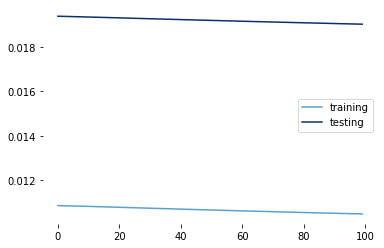

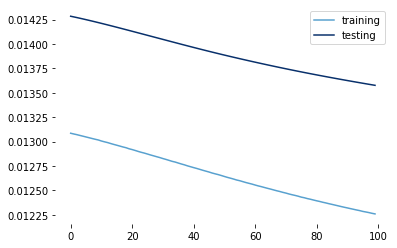

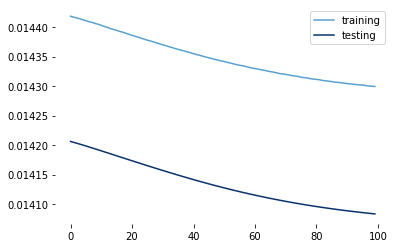

In [42]:
for v in history_ae.values():
  plt.plot(v.history['loss'], label='training', color=colors[5])
  plt.plot(v.history['val_loss'], label='testing', color=colors[9])
  for pos in ['right', 'top', 'bottom', 'left']:
      plt.gca().spines[pos].set_visible(False)
  plt.legend()
  plt.show()

### Encoder + Classifier

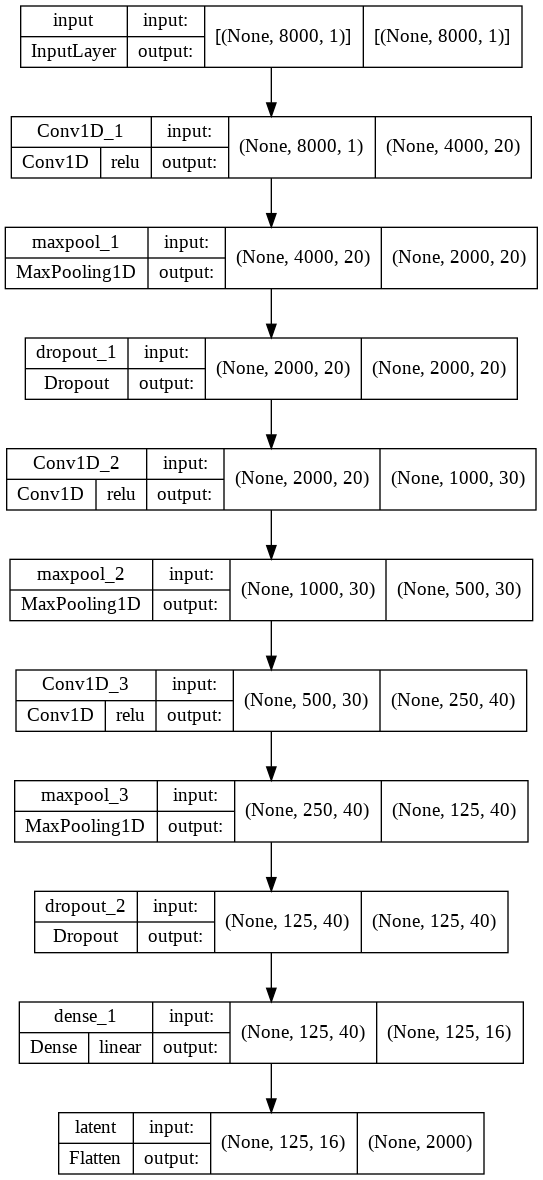

In [43]:
encoder_loaded = []
for n_model in range(3):
  encoder_loaded.append(load_model(saved_encoder_path.format(n_model), compile=False))
plot_model(encoder_loaded[0], show_shapes=True, show_layer_activations=True)

Predict each language emotion from its encoder-based raw representation.

In [44]:
X_train_encoded, X_test_encoded = [], []
for i,encoder in enumerate(encoder_loaded):
  X_train_encoded.append(encoder.predict(shaped_data[i]))
  X_test_encoded.append(encoder.predict(shaped_data_testing[i]))

SVM

In [45]:
eva, pre = [], []

for i,train_data in enumerate(X_train_encoded):
  class_weights = compute_class_w(target_labels_raw[i])
  classifier_SVC = SVC(kernel='rbf', class_weight=class_weights) 
  classifier_SVC.fit(train_data, target_labels_raw[i])

  pre.append(classifier_SVC.predict(X_test_encoded[i]))
  eva.append(cohen_kappa_score(target_labels_raw_testing[i], pre[i]))

evaluations['AE_raw_SVM']['predictions'] = pre
evaluations['AE_raw_SVM']['ckappa'] = eva

MLP

In [46]:
eva, pre = [], []
for i,train_data in enumerate(X_train_encoded):
  classifier_MLP = MLPClassifier((6,6)) 
  classifier_MLP.fit(train_data, target_labels_raw[i])

  pre.append(classifier_MLP.predict(X_test_encoded[i]))
  eva.append(cohen_kappa_score(target_labels_raw_testing[i], pre[i]))

evaluations['AE_raw_MLP']['predictions'] = pre
evaluations['AE_raw_MLP']['ckappa'] = eva

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


CNN



In [47]:
def build_cnn_encoded(print_summary=False):
  input_shape = (*X_train_encoded[0][0].shape,1)
  output_shape = n_classes

  model_mel = Sequential()
  model_mel.add(Conv1D(filters=16, kernel_size=100, strides=10, activation='relu', input_shape=input_shape))
  model_mel.add(Dropout(0.5))
  model_mel.add(MaxPooling1D(pool_size=3, padding='same'))
  model_mel.add(Flatten())
  model_mel.add(Dense(output_shape, activation='sigmoid'))

  if print_summary: model_mel.summary()
  return model_mel

def build_and_train_cnn_encoded(data,labels, testdata, testlabels):
  history = {}
  eva, pre = [], []
  for i,X in enumerate(data):
    # data
    x = np.expand_dims(np.array(X),axis=2)
    y = labels[i]

    # training
    model_mel = build_cnn_encoded()
    model_mel.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=[ckappa])

    history[i] = model_mel.fit(x, y, **model_params, class_weight = compute_class_w(y))

    # evaluation
    xt = np.expand_dims(np.array(testdata[i]),axis=2)
    yt = testlabels[i]
    eva.append(model_mel.evaluate(xt, yt)[1])
    pre.append(model_mel.predict(xt))

  evaluations['AE_raw_CNN']['ckappa'] = eva
  evaluations['AE_raw_CNN']['predictions'] = [np.argmax(p, axis=1) for p in pre]
  return history_mel

history_cnn_encoded = build_and_train_cnn_encoded(X_train_encoded, target_labels_raw, 
                                      X_test_encoded, target_labels_raw_testing)

Epoch 1/100
45/45 [==============================] - 1s 16ms/step - loss: 1.7968 - cohen_kappa: 0.0820 - val_loss: 1.7959 - val_cohen_kappa: 0.0000e+00
Epoch 2/100
45/45 [==============================] - 0s 9ms/step - loss: 1.7957 - cohen_kappa: -0.0199 - val_loss: 1.7973 - val_cohen_kappa: 0.0000e+00
Epoch 3/100
45/45 [==============================] - 0s 9ms/step - loss: 1.7965 - cohen_kappa: -0.0094 - val_loss: 1.7934 - val_cohen_kappa: 0.0000e+00
Epoch 4/100
45/45 [==============================] - 0s 9ms/step - loss: 1.7947 - cohen_kappa: -0.0061 - val_loss: 1.7932 - val_cohen_kappa: 2.1774e-04
Epoch 5/100
45/45 [==============================] - 0s 9ms/step - loss: 1.7936 - cohen_kappa: 0.0207 - val_loss: 1.8017 - val_cohen_kappa: 0.0000e+00
Epoch 6/100
45/45 [==============================] - 0s 9ms/step - loss: 1.7918 - cohen_kappa: -0.0065 - val_loss: 1.8003 - val_cohen_kappa: 0.0515
Epoch 7/100
45/45 [==============================] - 0s 9ms/step - loss: 1.7890 - cohen_kappa

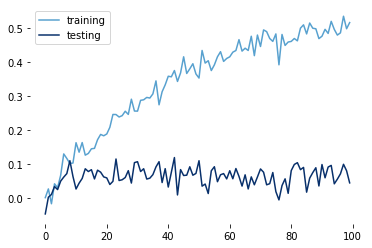

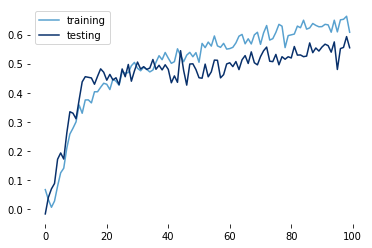

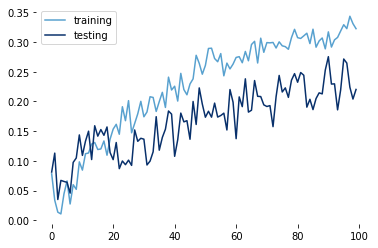

In [48]:
for v in history_cnn_encoded.values():
  plt.plot(v.history['cohen_kappa'], label='training', color=colors[5])
  plt.plot(v.history['val_cohen_kappa'], label='testing', color=colors[9])
  for pos in ['right', 'top', 'bottom', 'left']:
      plt.gca().spines[pos].set_visible(False)
  plt.legend()
  plt.show()

### Attach to encoded raw signal the features and train CNN 

In [49]:
which_datasets = (0,3)

signal_and_feature_data = []
for i in range(*which_datasets):
  signal_and_feature_data.append(
      [np.concatenate((x[0].reshape(2000//16,16),x[1]), axis=0) for x in zip(X_train_encoded[i], feature_ds[i])]
      )
full_dataset = np.vstack(signal_and_feature_data)
full_dataset.shape

(2827, 166, 16)

In [50]:
signal_and_feature_data_testing = []
for i in range(*which_datasets):
  signal_and_feature_data_testing.append(
      [np.concatenate((x[0].reshape(2000//16,16),x[1]), axis=0) for x in zip(X_test_encoded[i], feature_testing[i])]
      )
full_dataset_testing = np.vstack(signal_and_feature_data_testing)
full_dataset_testing.shape

(1190, 166, 16)

In [51]:
full_target_labels = np.concatenate([t for t in target_labels_raw[which_datasets[0]:which_datasets[1]]])
full_target_labels_testing = np.concatenate([t for t in target_labels_raw_testing[which_datasets[0]:which_datasets[1]]])
full_target_labels.shape, full_target_labels_testing.shape

((2827,), (1190,))

Train each dataset alone.

In [52]:
def build_cnn_sf(print_summary=False):
  input_shape = (*full_dataset[0].shape,1)
  output_shape = n_classes

  model_sf = Sequential()
  model_sf.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation='relu', input_shape=input_shape))
  model_sf.add(Dropout(0.5))
  model_sf.add(MaxPooling2D(pool_size=3, padding='same'))
  model_sf.add(Flatten())
  model_sf.add(Dense(output_shape, activation='sigmoid'))

  if print_summary: model_sf.summary()
  return model_sf

In [53]:
def build_and_train_cnn_sf(data,labels,datatest,labelstest):
  # data
  eva, pre = [], []
  history = {}
  for i,X in enumerate(data):
    x = np.expand_dims(X, axis=3)
    y = labels[i]

    # training
    model_sf = build_cnn_sf()
    model_sf.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=[ckappa])

    history[i] = model_sf.fit(x, y, **model_params_sf, class_weight = compute_class_w(y))

    # evaluation
    xt = np.expand_dims(np.array(datatest[i]),axis=3)
    yt = labelstest[i]
    eva.append(model_sf.evaluate(xt, yt)[1])
    pre.append(np.argmax(model_sf.predict(xt), axis=1))

  evaluations['AE_feat_raw_CNN']['ckappa'] = eva
  evaluations['AE_feat_raw_CNN']['predictions'] = pre
  return history

model_params_sf = {
    'batch_size':16, 
    'epochs':100, 
    'verbose':1, 
    'validation_split':0.2,
    'shuffle':True
}

history_sf = build_and_train_cnn_sf(signal_and_feature_data, target_labels_raw, 
                                    signal_and_feature_data_testing, target_labels_raw_testing)

Epoch 1/100
45/45 [==============================] - 2s 31ms/step - loss: 178.3607 - cohen_kappa: 0.0229 - val_loss: 129.8510 - val_cohen_kappa: 0.0332
Epoch 2/100
45/45 [==============================] - 1s 24ms/step - loss: 91.8474 - cohen_kappa: 0.0764 - val_loss: 78.2196 - val_cohen_kappa: 0.0387
Epoch 3/100
45/45 [==============================] - 1s 25ms/step - loss: 51.6548 - cohen_kappa: 0.1337 - val_loss: 56.6392 - val_cohen_kappa: -0.0020
Epoch 4/100
45/45 [==============================] - 1s 25ms/step - loss: 29.4353 - cohen_kappa: 0.2103 - val_loss: 41.8990 - val_cohen_kappa: 0.0613
Epoch 5/100
45/45 [==============================] - 1s 25ms/step - loss: 17.8228 - cohen_kappa: 0.2659 - val_loss: 28.6142 - val_cohen_kappa: 0.0449
Epoch 6/100
45/45 [==============================] - 1s 24ms/step - loss: 12.8560 - cohen_kappa: 0.3280 - val_loss: 22.1396 - val_cohen_kappa: 0.0836
Epoch 7/100
45/45 [==============================] - 1s 25ms/step - loss: 8.3423 - cohen_kappa: 0

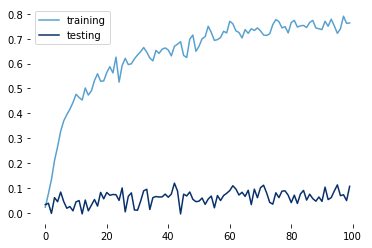

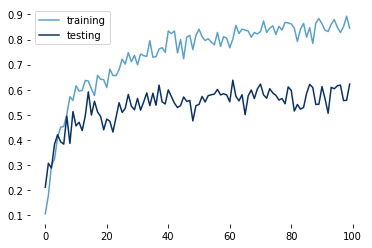

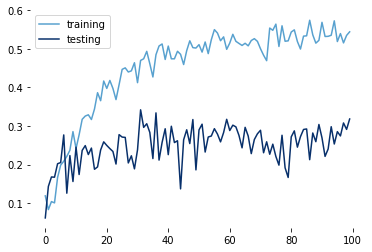

In [54]:
for v in history_sf.values():
  plt.plot(v.history['cohen_kappa'], label='training', color=colors[5])
  plt.plot(v.history['val_cohen_kappa'], label='testing', color=colors[9])
  for pos in ['right', 'top', 'bottom', 'left']:
      plt.gca().spines[pos].set_visible(False)
  plt.legend()
  plt.show()

Whole dataset (all examples from EMOVO, EMODB, RAVDESS)

In [55]:
def build_and_train_cnn_all_sf(data,labels,datatest,labelstest):
  # data
  x = np.expand_dims(data, axis=3)
  y = labels

  # training
  model_sf = build_cnn_sf()
  model_sf.compile(
  loss='sparse_categorical_crossentropy', 
  optimizer='adam', 
  metrics=[ckappa])

  model_params_all_sf = {
    'batch_size':16, 
    'epochs':300, 
    'verbose':1, 
    'validation_split':0.2,
    'shuffle':True
  }

  history_sf = model_sf.fit(x, y, **model_params_all_sf, class_weight = compute_class_w(y))

  # evaluation
  xt = np.expand_dims(np.array(datatest),axis=3)
  yt = labelstest

  evaluations['AE_feat_raw_all_CNN']['ckappa'] = model_sf.evaluate(xt, yt)[1]
  evaluations['AE_feat_raw_all_CNN']['predictions'] = np.argmax(model_sf.predict(xt), axis=1)
  return history_sf

history_all_sf = build_and_train_cnn_all_sf(full_dataset, full_target_labels, 
                                    full_dataset_testing, full_target_labels_testing,)

Epoch 1/300
142/142 [==============================] - 4s 27ms/step - loss: 32.8364 - cohen_kappa: 0.1043 - val_loss: 4.8065 - val_cohen_kappa: 0.0610
Epoch 2/300
142/142 [==============================] - 3s 24ms/step - loss: 9.0641 - cohen_kappa: 0.1853 - val_loss: 5.0179 - val_cohen_kappa: 0.0618
Epoch 3/300
142/142 [==============================] - 3s 24ms/step - loss: 5.4013 - cohen_kappa: 0.1996 - val_loss: 2.9050 - val_cohen_kappa: 0.1040
Epoch 4/300
142/142 [==============================] - 3s 24ms/step - loss: 3.6603 - cohen_kappa: 0.2217 - val_loss: 3.2583 - val_cohen_kappa: 0.0120
Epoch 5/300
142/142 [==============================] - 3s 24ms/step - loss: 3.2150 - cohen_kappa: 0.2242 - val_loss: 2.8006 - val_cohen_kappa: 0.0368
Epoch 6/300
142/142 [==============================] - 3s 24ms/step - loss: 2.6081 - cohen_kappa: 0.2803 - val_loss: 2.5878 - val_cohen_kappa: 0.0444
Epoch 7/300
142/142 [==============================] - 3s 24ms/step - loss: 2.2380 - cohen_kappa: 0

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 164, 14, 16)       160       
                                                                 
 dropout_12 (Dropout)        (None, 164, 14, 16)       0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 55, 5, 16)        0         
 2D)                                                             
                                                                 
 flatten_12 (Flatten)        (None, 4400)              0         
                                                                 
 dense_12 (Dense)            (None, 6)                 26406     
                                                                 
Total params: 26,566
Trainable params: 26,566
Non-trainable params: 0
_________________________________________________

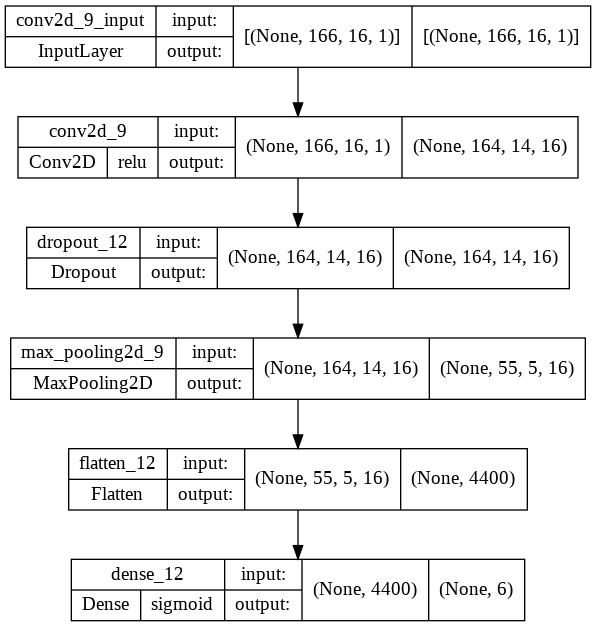

In [56]:
plot_model(build_cnn_sf(print_summary=True), show_shapes=True, show_layer_activations=True)

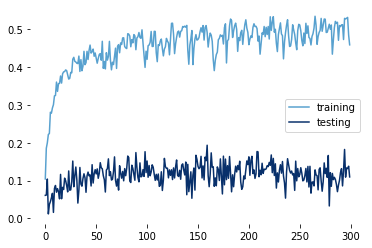

In [57]:
plt.plot(history_all_sf.history['cohen_kappa'], label='training', color=colors[5])
plt.plot(history_all_sf.history['val_cohen_kappa'], label='testing', color=colors[9])
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.legend()
plt.show()

# Evaluation on Test Data

## Confusion Matrix

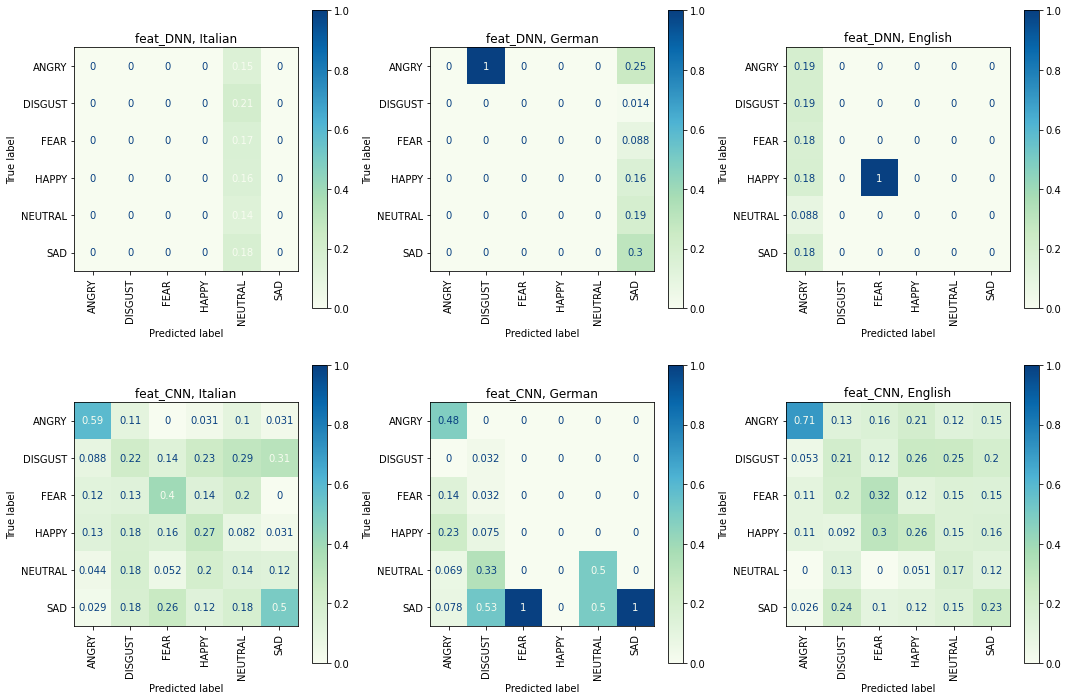

In [58]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))
for j,model in enumerate(['feat_DNN', 'feat_CNN']):
  for i in range(3):
    cm = ConfusionMatrixDisplay.from_predictions(target_labels_raw_testing[i], evaluations[model]['predictions'][i],  display_labels=LabelEncoder_2.classes_,
                                              cmap='GnBu', xticks_rotation='vertical',ax=axs[j,i], normalize='pred')
    cm.ax_.get_images()[0].set_clim(0, 1)
    axs[j,i].title.set_text(f'{model}, {lang_str[i]}')
plt.tight_layout()  
plt.show()

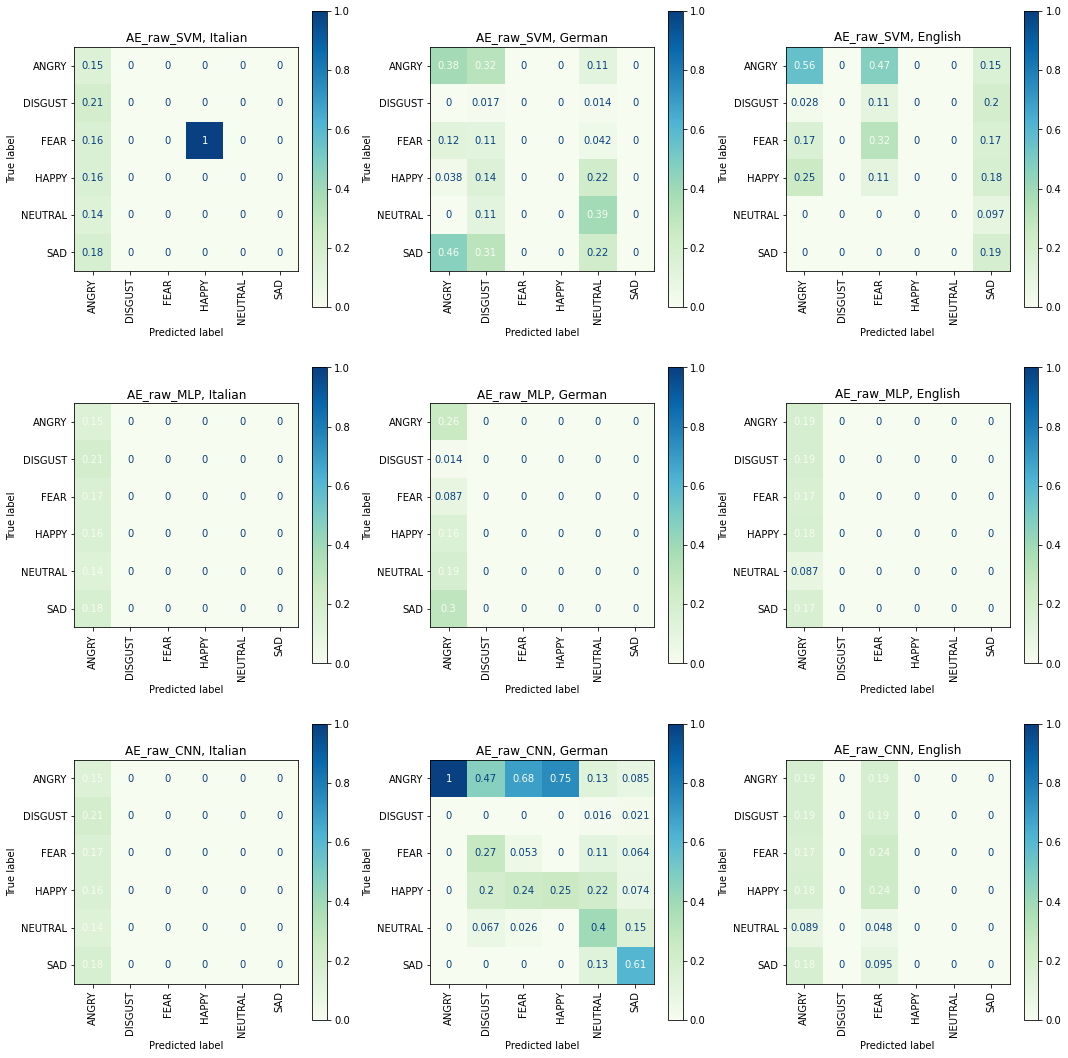

In [59]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))
for j,model in enumerate(['AE_raw_SVM','AE_raw_MLP','AE_raw_CNN']):
  for i in range(3):
    cm = ConfusionMatrixDisplay.from_predictions(target_labels_raw_testing[i], evaluations[model]['predictions'][i],  display_labels=LabelEncoder_2.classes_,
                                              cmap='GnBu', xticks_rotation='vertical',ax=axs[j,i], normalize='pred')
    cm.ax_.get_images()[0].set_clim(0, 1)
    axs[j,i].title.set_text(f'{model}, {lang_str[i]}')
plt.tight_layout()  
plt.show()

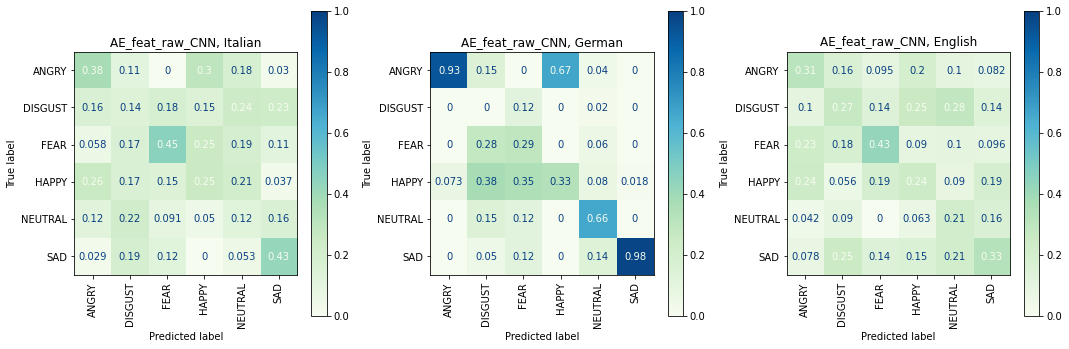

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for i in range(3):
  cm = ConfusionMatrixDisplay.from_predictions(target_labels_raw_testing[i], evaluations['AE_feat_raw_CNN']['predictions'][i],  display_labels=LabelEncoder_2.classes_,
                                            cmap='GnBu', xticks_rotation='vertical',ax=axs[i], normalize='pred')
  cm.ax_.get_images()[0].set_clim(0, 1)
  axs[i].title.set_text(f'AE_feat_raw_CNN, {lang_str[i]}')
plt.tight_layout()  
plt.show()

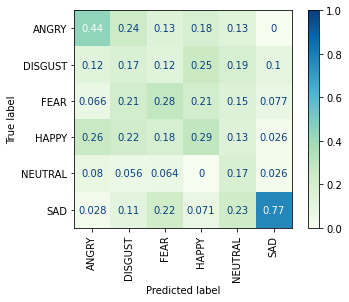

In [61]:
cm = ConfusionMatrixDisplay.from_predictions(full_target_labels_testing, evaluations['feat_all_CNN']['predictions'],  display_labels=LabelEncoder_2.classes_,
                                            cmap='GnBu', xticks_rotation='vertical', normalize='pred')
cm.ax_.get_images()[0].set_clim(0, 1)

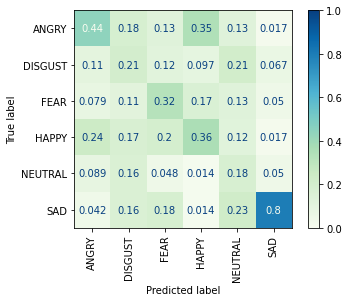

In [62]:
cm = ConfusionMatrixDisplay.from_predictions(full_target_labels_testing, evaluations['AE_feat_raw_all_CNN']['predictions'],  display_labels=LabelEncoder_2.classes_,
                                            cmap='GnBu', xticks_rotation='vertical', normalize='pred')
cm.ax_.get_images()[0].set_clim(0, 1)

## Cohen Kappa

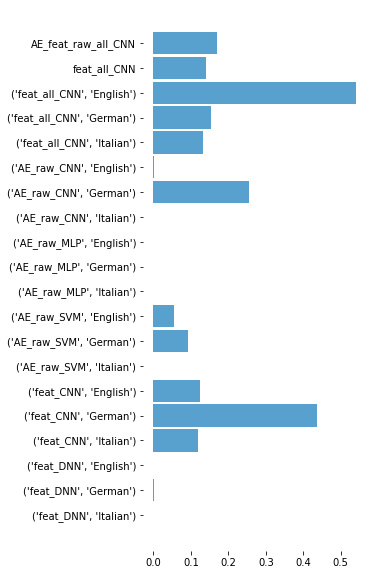

In [70]:
from itertools import product, chain

evaluations['AE_feat_raw_all_CNN']['ckappa'] = [evaluations['AE_feat_raw_all_CNN']['ckappa']]
evaluations['feat_all_CNN']['ckappa'] = [evaluations['feat_all_CNN']['ckappa']]

models_str = list(evaluations.keys())
models_list = list(product(models_str[:-2], lang_str)) 

kappas = list(chain(*[evaluations[model]['ckappa'] for model in models_str]))
kappas_list = list(zip([*models_list,'feat_all_CNN','AE_feat_raw_all_CNN'],kappas))

plt.figure(figsize=(4,10))
plt.barh(range(len(kappas_list)), [k[1] for k in kappas_list], color=colors[5], height=0.9)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.gca().set_yticklabels([k[0] for k in kappas_list], rotation=0)
plt.yticks(np.arange(0, len(kappas_list), step=1))
plt.show()

In [71]:
[(k,round(v,3)) for k,v in kappas_list]

[(('feat_DNN', 'Italian'), 0.0),
 (('feat_DNN', 'German'), 0.002),
 (('feat_DNN', 'English'), 0.0),
 (('feat_CNN', 'Italian'), 0.12),
 (('feat_CNN', 'German'), 0.436),
 (('feat_CNN', 'English'), 0.124),
 (('AE_raw_SVM', 'Italian'), -0.0),
 (('AE_raw_SVM', 'German'), 0.092),
 (('AE_raw_SVM', 'English'), 0.056),
 (('AE_raw_MLP', 'Italian'), 0.0),
 (('AE_raw_MLP', 'German'), 0.0),
 (('AE_raw_MLP', 'English'), 0.0),
 (('AE_raw_CNN', 'Italian'), 0.0),
 (('AE_raw_CNN', 'German'), 0.254),
 (('AE_raw_CNN', 'English'), 0.003),
 (('feat_all_CNN', 'Italian'), 0.133),
 (('feat_all_CNN', 'German'), 0.153),
 (('feat_all_CNN', 'English'), 0.542),
 ('feat_all_CNN', 0.141),
 ('AE_feat_raw_all_CNN', 0.171)]